# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/backprop_diagram.png' width=550px>

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [ ]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### Note
If you haven't seen `nn.Sequential` yet, please finish the end of the Part 2 notebook.

In [3]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2995, grad_fn=<NllLossBackward>)


In my experience it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.

In [4]:
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
dataiter = iter(trainloader)

images, labels = next(dataiter)

# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3439, grad_fn=<NllLossBackward>)


## Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [5]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.4410,  0.1500],
        [-0.3398,  1.9679]], requires_grad=True)


In [6]:
y = x**2
print(y)

tensor([[2.0765, 0.0225],
        [0.1155, 3.8725]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [7]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [8]:
z = y.mean()
print(z)

tensor(1.5217, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [9]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [10]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.7205,  0.0750],
        [-0.1699,  0.9839]])
tensor([[ 0.7205,  0.0750],
        [-0.1699,  0.9839]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the cost with respect to the weights. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step. 

## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [11]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [12]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0032,  0.0032,  0.0032,  ...,  0.0032,  0.0032,  0.0032],
        [-0.0050, -0.0050, -0.0050,  ..., -0.0050, -0.0050, -0.0050],
        ...,
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007]])


## Training the network!

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [13]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [14]:
print('Initial weights - ', model[0].weight)

dataiter = iter(trainloader)
images, labels = next(dataiter)
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0156, -0.0306, -0.0095,  ..., -0.0143,  0.0329,  0.0228],
        [ 0.0339,  0.0020,  0.0266,  ...,  0.0113, -0.0258, -0.0083],
        [-0.0155, -0.0240, -0.0149,  ...,  0.0085, -0.0232,  0.0177],
        ...,
        [ 0.0258, -0.0033,  0.0236,  ..., -0.0137, -0.0053, -0.0211],
        [ 0.0328, -0.0167,  0.0152,  ..., -0.0158,  0.0124, -0.0011],
        [-0.0128, -0.0245,  0.0329,  ..., -0.0086, -0.0357,  0.0161]],
       requires_grad=True)
Gradient - tensor([[-0.0024, -0.0024, -0.0024,  ..., -0.0024, -0.0024, -0.0024],
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0029,  0.0029,  0.0029,  ...,  0.0029,  0.0029,  0.0029],
        ...,
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010]])


In [15]:
# Take an update step and view the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0156, -0.0306, -0.0095,  ..., -0.0143,  0.0329,  0.0229],
        [ 0.0339,  0.0021,  0.0267,  ...,  0.0114, -0.0258, -0.0082],
        [-0.0155, -0.0241, -0.0149,  ...,  0.0084, -0.0233,  0.0177],
        ...,
        [ 0.0258, -0.0033,  0.0236,  ..., -0.0137, -0.0053, -0.0211],
        [ 0.0328, -0.0167,  0.0152,  ..., -0.0158,  0.0124, -0.0011],
        [-0.0128, -0.0245,  0.0329,  ..., -0.0086, -0.0357,  0.0161]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll be doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Exercise:** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [17]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        # TODO: Training pass
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9866727318590893
Training loss: 0.9147747276879069
Training loss: 0.545202063472032
Training loss: 0.44012413993636684
Training loss: 0.3916750731530474


With the network trained, we can check out it's predictions.

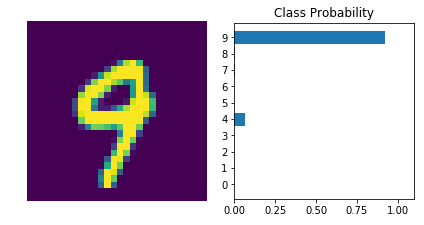

In [18]:
%matplotlib inline
import helper

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.